In [17]:
# Actor-Critic for Portfolio Optimization

import numpy as np
import pandas as pd
import yfinance as yf
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
import random
import matplotlib.pyplot as plt

In [18]:
# Define the 10 assets (tickers) for the portfolio
# tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "BA", "NFLX", "NVDA", "META", "SBUX"]

tickers = ["AAPL", "MSFT", "GOOGL", "SBUX", "TSLA"]
# tickers = ["GME", "AMC", "SPCE", "NVAX", "NOK"]
# tickers = ["GME", "AMC", "BB", "NVAX", "NOK"]
# tickers = ["GME", "AMC", "HMC", "NVAX", "NOK"]
# Date range for historical data
start_date = "2017-01-01"
end_date   = "2023-12-31"

# Try to load price data from a local CSV, otherwise download using yfinance
data_file = "prices.csv"
try:
    prices_df = pd.read_csv(data_file, index_col=0, parse_dates=True)
    print("Loaded data from", data_file)
except FileNotFoundError:
    print("Downloading price data for tickers:", tickers)
    df = yf.download(tickers, start=start_date, end=end_date, interval="1d")
    # Extract the 'Close' prices from the MultiIndex DataFrame
    prices_df = df.xs('Close', axis=1, level='Price')
    prices_df.dropna(inplace=True)
    prices_df.to_csv(data_file)
    print("Data downloaded and saved to", data_file)

# Split data into training (first 4 years) and testing (last year)
full_train_df = prices_df[prices_df.index < "2023-01-01"]
test_df  = prices_df[prices_df.index >= "2023-01-01"]
full_train_prices = full_train_df.values  # shape: [train_days, 5]
test_prices  = test_df.values   # shape: [test_days, 5]
num_assets = full_train_prices.shape[1]
print(f"Training days: {full_train_prices.shape[0]}, Testing days: {test_prices.shape[0]}")

# Further split full training into training and validation (80/20)
split_index = int(0.8 * full_train_prices.shape[0])
train_prices = full_train_prices[:split_index]
val_prices   = full_train_prices[split_index:]

Loaded data from prices.csv
Training days: 1510, Testing days: 250


In [19]:
# --- 2. State/Action Representation ---
def encode_state(increments):
    return "".join(chr(ord('A') + inc) for inc in increments)

def decode_state(state_str):
    return tuple(ord(ch) - ord('A') for ch in state_str)

actions = [(i, j) for i in range(num_assets) for j in range(num_assets) if i != j]
actions.append((None, None))

def get_valid_actions(state):
    increments = decode_state(state) if isinstance(state, str) else state
    valid = []
    for (i, j) in actions:
        if i is None and j is None:
            valid.append((None, None))
            continue
        if i is None or j is None:
            continue
        if increments[i] >= 1 and increments[j] <= 19:
            valid.append((i, j))
    return valid

def apply_action(state, action):
    increments = list(state)
    if action == (None, None):
        return tuple(increments)
    i, j = action
    if increments[i] >= 1 and increments[j] <= 19:
        increments[i] -= 1
        increments[j] += 1
    return tuple(increments)

def compute_reward(weight_frac, price_today, price_next):
    growth = sum(weight_frac[k] * (price_next[k] / price_today[k]) for k in range(num_assets))
    return math.log(growth)


In [20]:
# --- 3. Actor-Critic Networks ---
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [21]:
# --- 4. Training Loop ---
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state'])
def state_to_tensor(state):
    return torch.tensor([x / 20.0 for x in state], dtype=torch.float32)

def action_to_index(action):
    return actions.index(action)

def index_to_action(index):
    return actions[index]

actor = Actor(5, len(actions))
critic = Critic(5)
optimizerA = optim.Adam(actor.parameters(), lr=1e-3)
optimizerC = optim.Adam(critic.parameters(), lr=1e-3)

gamma = 0.99
episodes = 100
initial_state = (4, 4, 4, 4, 4)
episode_rewards = []

for ep in range(episodes):
    state = initial_state
    total_reward = 0
    for t in range(train_prices.shape[0] - 1):
        s_tensor = state_to_tensor(state)
        probs = actor(s_tensor)
        valid_acts = get_valid_actions(state)
        valid_idxs = [action_to_index(a) for a in valid_acts]

        filtered_probs = probs[valid_idxs]
        filtered_probs /= filtered_probs.sum()
        dist = torch.distributions.Categorical(filtered_probs)
        act_idx = valid_idxs[dist.sample().item()]
        action = index_to_action(act_idx)

        next_state = apply_action(state, action)
        weights_new = [x / 20.0 for x in next_state]
        reward = compute_reward(weights_new, train_prices[t], train_prices[t + 1])
        total_reward += reward

        s_next_tensor = state_to_tensor(next_state)
        v_s = critic(s_tensor)
        v_s_next = critic(s_next_tensor).detach()
        td_target = reward + gamma * v_s_next
        td_error = td_target - v_s

        critic_loss = td_error.pow(2)
        optimizerC.zero_grad()
        critic_loss.backward()
        optimizerC.step()

        log_prob = torch.log(probs[act_idx])
        actor_loss = -log_prob * td_error.detach()
        optimizerA.zero_grad()
        actor_loss.backward()
        optimizerA.step()

        state = next_state
    episode_rewards.append(total_reward)
    print(f"Episode {ep+1} completed, Total Reward: {total_reward:.4f}")

print("Training completed.")

Episode 1 completed, Total Reward: 1.1977
Episode 2 completed, Total Reward: 1.6612
Episode 3 completed, Total Reward: 1.6355
Episode 4 completed, Total Reward: 1.6844
Episode 5 completed, Total Reward: 1.6357
Episode 6 completed, Total Reward: 1.6409
Episode 7 completed, Total Reward: 1.6725
Episode 8 completed, Total Reward: 1.6433
Episode 9 completed, Total Reward: 1.6757
Episode 10 completed, Total Reward: 1.6429
Episode 11 completed, Total Reward: 1.5096
Episode 12 completed, Total Reward: 1.7089
Episode 13 completed, Total Reward: 1.6476
Episode 14 completed, Total Reward: 1.6778
Episode 15 completed, Total Reward: 1.8221
Episode 16 completed, Total Reward: 1.9115
Episode 17 completed, Total Reward: 1.8559
Episode 18 completed, Total Reward: 1.7672
Episode 19 completed, Total Reward: 1.6144
Episode 20 completed, Total Reward: 1.7389
Episode 21 completed, Total Reward: 1.6905
Episode 22 completed, Total Reward: 1.7656
Episode 23 completed, Total Reward: 1.7070
Episode 24 completed

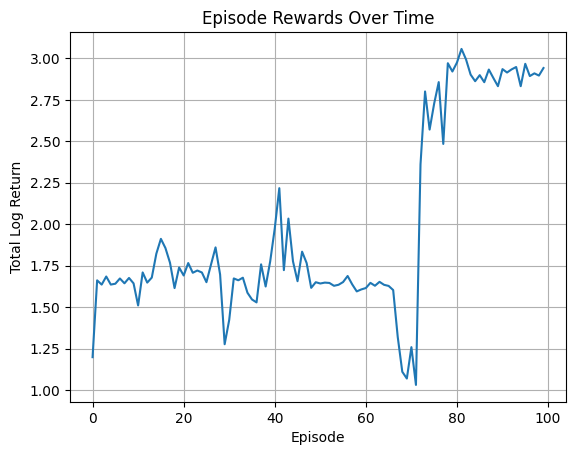

In [22]:
# --- 5. Plot Training Rewards ---
plt.plot(episode_rewards)
plt.title("Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Log Return")
plt.grid(True)
plt.show()

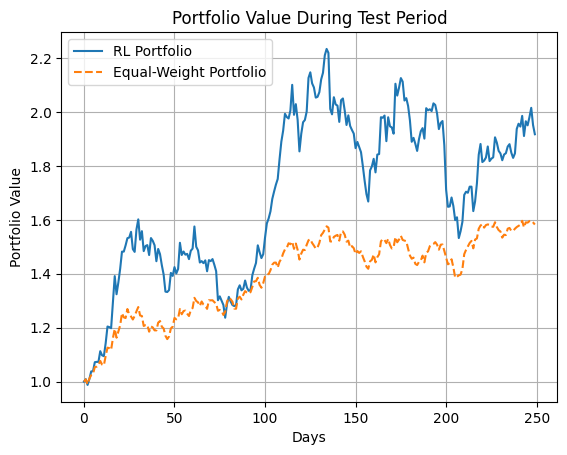

In [23]:
# --- 6. Test Policy Performance (RL vs Baseline) ---
state = initial_state
portfolio_value_rl = [1.0]
log_returns = []

# RL-driven portfolio
for t in range(test_prices.shape[0] - 1):
    s_tensor = state_to_tensor(state)
    with torch.no_grad():
        probs = actor(s_tensor)
    valid_acts = get_valid_actions(state)
    valid_idxs = [action_to_index(a) for a in valid_acts]
    filtered_probs = probs[valid_idxs]
    filtered_probs /= filtered_probs.sum()
    dist = torch.distributions.Categorical(filtered_probs)
    act_idx = valid_idxs[dist.sample().item()]
    action = index_to_action(act_idx)

    next_state = apply_action(state, action)
    weights_new = [x / 20.0 for x in next_state]
    reward = compute_reward(weights_new, test_prices[t], test_prices[t + 1])
    log_returns.append(reward)
    portfolio_value_rl.append(portfolio_value_rl[-1] * math.exp(reward))
    state = next_state

# Equal-weight (baseline) portfolio
portfolio_value_eq = [1.0]
weights_equal = [1.0 / num_assets] * num_assets
for t in range(test_prices.shape[0] - 1):
    reward_eq = compute_reward(weights_equal, test_prices[t], test_prices[t + 1])
    portfolio_value_eq.append(portfolio_value_eq[-1] * math.exp(reward_eq))

# Plot both
plt.plot(portfolio_value_rl, label="RL Portfolio")
plt.plot(portfolio_value_eq, label="Equal-Weight Portfolio", linestyle="--")
plt.title("Portfolio Value During Test Period")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# --- 7. Sharpe Ratio Calculation ---
daily_returns = np.exp(log_returns) - 1
average_return = np.mean(daily_returns)
volatility = np.std(daily_returns)
sharpe_ratio = (average_return / volatility) * np.sqrt(252)  # 252 trading days/year

print(f"\nSharpe Ratio on Test Set (RL Portfolio): {sharpe_ratio:.4f}")
print(f"Portfolio return: {(portfolio_value_rl[-1]-1)*100:.2f}%")


Sharpe Ratio on Test Set (RL Portfolio): 1.6635
Portfolio return: 91.74%
